In [49]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import math as m
df = pd.read_csv('C:/Users/cathy.chen/Desktop/采鈺/CPA_python/File/Case_1.csv', index_col=0)
# readfile to analysis for single Y

col_names = df.columns
var_Y = col_names[0]
var_X = col_names[1]

df[var_X] = pd.to_datetime(df[var_X])
df = df.sort_values(var_X)

data_Y = df[var_Y]
data_X = pd.to_datetime(df[var_X])
data_X.index = range(len(data_X))
input_val = data_Y.values
#####ruptures 參數設定
algo = rpt.Binseg(model="normal").fit(input_val)
my_bkps = algo.predict(n_bkps=10, pen=0.01)
#####def output_table
def cpa_flow(my_bkps):
    start = 0
    mean = []
    before_mean = []
    after_mean = []
    median = []
    before_median = []
    after_median = []
    var = []
    before_var = []
    after_var = []
    sigma = []
    before_sigma =[]
    after_sigma = []
    size = []
    before_size = []
    after_size = []
    start_cut = []
    end_cut = []
    start_time = []
    end_time = []
    cut_point = []
    # calculate mean var std
    for point in my_bkps:
        end = point-1
        start_cut.append(str(data_X[start]))
        end_cut.append(str(data_X[end]))
        start_time = start_cut[:-1]
        cut_point = end_cut[:-1]
        end_time = start_cut[1:]
        interval_data = input_val[start:end]
        start=point
        mean.append(np.mean(interval_data, dtype=np.float64))
        before_mean = mean[:-1]
        after_mean = mean[1:]
        median.append(np.median(interval_data))
        before_median = median[:-1]
        after_median = median[1:]
        var.append(np.var(interval_data))
        before_var = var[:-1]
        after_var = var[1:]
        sigma.append(np.std(interval_data, dtype=np.float64))
        for n, i in enumerate(sigma):
            if i == 0:
                sigma[n] = 0.0000000001
        before_sigma = sigma[:-1]
        after_sigma = sigma[1:]
        size.append(len(interval_data))
        before_size = size[:-1]
        after_size = size[1:]

    output_table = pd.DataFrame(data = {'start_time':start_time,'cut_point':cut_point,'end_time':end_time,'before_mean':before_mean,'after_mean':after_mean,'before_median':before_median,'after_median':after_median,'before_var':before_var,'after_var':after_var,'before_sigma':before_sigma,'after_sigma':after_sigma,'before_size':before_size,'after_size':after_size})
    my_bkps = []
    temp = 0
    for i in output_table.before_size:
        temp+=i+1
        my_bkps.append(temp)
    output_table['bkp'] = my_bkps
    output_table['mean_diff'] = output_table.after_mean - output_table.before_mean
    #####計算difference
    before = abs(output_table.mean_diff)/output_table.before_sigma
    after = abs(output_table.mean_diff)/output_table.after_sigma
    a = np.sqrt(output_table.before_size)*before
    b = np.sqrt(output_table.after_size)*after
    difference = np.maximum(a,b)
    difference = pd.DataFrame({'difference':(difference)})
    #####計算p value
#     mean1 = output_table.before_mean
#     mean2 = output_table.after_mean
#     std1 = output_table.before_sigma
#     std2 = output_table.after_sigma
#     nobs1 = len(output_table)
#     nobs2 = len(output_table)
#     modified_std1 = np.sqrt(np.float32(nobs1)/np.float32(nobs1-1)) * std1
#     modified_std2 = np.sqrt(np.float32(nobs2)/np.float32(nobs2-1)) * std2
#     (statistic, pvalue) = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1 = nobs1, mean2=mean2, std2=std2, nobs2=nobs2)
    p_value = pd.DataFrame({'p_value':stats.ttest_ind(output_table.before_sigma,output_table.after_sigma)})
#     p_value = pd.DataFrame({'p_value':pvalue})
    output_table = pd.concat([output_table,difference,p_value],axis = 1)
    #####門檻值計算
    var_diff_before = abs(output_table.mean_diff) / output_table.before_sigma
    var_diff_after = abs(output_table.mean_diff) / output_table.after_sigma
    var_multiple_before = 1.5*output_table.before_sigma
    var_multiple_after = 1.5*output_table.after_sigma
    var_count = pd.DataFrame({'var_diff_before':(var_diff_before),
                             'var_diff_after':(var_diff_after),
                             'var_multiple_before':(var_multiple_before),
                             'var_multiple_after':(var_multiple_after)})
    return [output_table,var_count]

In [50]:
output_table,var_count = cpa_flow(my_bkps)
new_bkp = [1111]
#樣本數門檻值
var_size = 25
#p value 門檻值
var_pvalue = 0.05
#####sigma門檻值
while True:
    #print(my_bkps)
    #print(new_bkp)
    #print(1111111111111111111111111111111111)
    if my_bkps != new_bkp:
        my_bkps = new_bkp
        if ((var_count.var_diff_before) < (var_count.var_multiple_before)).any() == True & ((var_count.var_diff_after) < (var_count.var_multiple_after)).any() == True:
            output_table = output_table.drop(var_count[(var_count.var_diff_before < var_count.var_multiple_before) & (var_count.var_diff_after < var_count.var_multiple_after)].index)
            new_bkp = [i for i in output_table.bkp]+[len(data_Y)]
            output_table,var_count = cpa_flow(new_bkp)
    else:
        break

run = 0      
####樣本數 if after size < 25 then drop
while True:
    #print(my_bkps)
    #print(new_bkp)
    #print(2222222222222222222222222222222222)
    if run==0:
        my_bkps = new_bkp
        if ((output_table.after_size) < (var_size)).any() == True:
            output_table = output_table.drop(output_table[output_table.after_size < var_size].index)
            output_table.index = range(len(output_table))
            new_bkp = [i for i in output_table.bkp]+[len(data_Y)]
            output_table,var_count = cpa_flow(new_bkp)
        run = 1
    else:
        if my_bkps != new_bkp:
            my_bkps = new_bkp
            if ((output_table.after_size) < (var_size)).any() == True:
                output_table = output_table.drop(output_table[output_table.after_size < var_size].index)
                output_table.index = range(len(output_table))
                new_bkp = [i for i in output_table.bkp]+[len(data_Y)]
                output_table,var_count = cpa_flow(new_bkp)
        else:
            break       


#####樣本數 if before_size第一筆 < 25 then drop
run = 0  
while True:
    #print(my_bkps)
    #print(new_bkp)
    #print(3333333333333333333333333333333333)
    if run==0:
        my_bkps = new_bkp
        if ((output_table.before_size[0]) < (var_size)) == True:
            output_table = output_table.drop(output_table[output_table.before_size <  var_size].index[0])
            new_bkp = [i for i in output_table.bkp]+[len(data_Y)]
            output_table,var_count = cpa_flow(new_bkp)
        run = 1
    else:
        if my_bkps != new_bkp:
            my_bkps = new_bkp
            if ((output_table.before_size[0]) < (var_size)) == True:
                output_table = output_table.drop(output_table[output_table.before_size <  var_size].index[0])
                new_bkp = [i for i in output_table.bkp]+[len(data_Y)]
                output_table,var_count = cpa_flow(new_bkp)
        else:
            break  

# run = 0 
# ##### if p-value > 0.05 then drop
# while True:
#     print(my_bkps)
#     print(new_bkp)
#     print(444444444444444444444444444444444)
#     if run==0:
#         my_bkps = new_bkp
#         if ((output_table.p_value) > (var_pvalue)).any() :
#             output_table = output_table.drop(output_table[output_table.p_value > var_pvalue].index)
#             new_bkp = [i for i in output_table.bkp]+[len(data_Y)]
#             output_table,var_count = cpa_flow(new_bkp)
#         run=1
#     else:
#         if my_bkps != new_bkp:
#             my_bkps = new_bkp
#             if ((output_table.p_value) > (var_pvalue)).any() :
#                 output_table = output_table.drop(output_table[output_table.p_value > var_pvalue].index)
#                 new_bkp = [i for i in output_table.bkp]+[len(data_Y)]
#                 output_table,var_count = cpa_flow(new_bkp)
#         else:
#             break          
# #print(output_table)   
# # print(output_table.sort_values(by=['difference'],ascending = False))

# new_bkp = output_table.bkp
# new_bkp

In [51]:
output_table.sort_values(by=['difference'],ascending = False)
###門檻值table
#var_count

,start_time,cut_point,end_time,before_mean,after_mean,before_median,after_median,before_var,after_var,before_sigma,after_sigma,before_size,after_size,bkp,mean_diff,difference,p_value
2,2018-06-11 20:56:00,2018-08-14 19:11:00,2018-08-14 21:46:00,1.124241,0.004205,0.364465,0.000000,5.836514,0.000302,2.415888,0.017367,384,65,805,-1.120035,519.939620,NaN
1,2018-06-06 09:02:00,2018-06-11 19:22:00,2018-06-11 20:56:00,0.085485,1.124241,0.045558,0.364465,0.017715,5.836514,0.133099,2.415888,89,384,420,1.038755,73.626452,0.992363
0,2017-04-18 17:44:00,2018-06-06 08:22:00,2018-06-06 09:02:00,0.021325,0.085485,0.000000,0.045558,0.002599,0.017715,0.050977,0.133099,329,89,330,0.064160,22.829337,0.010183


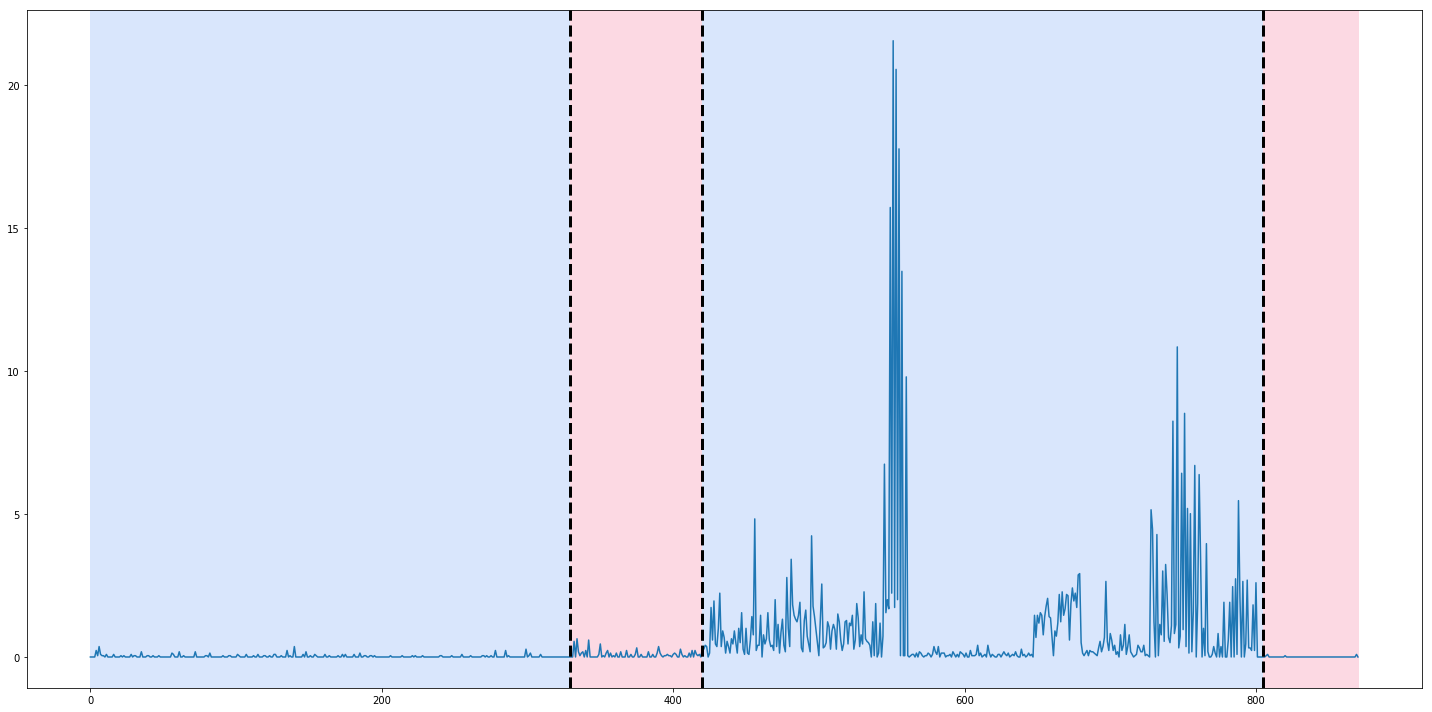

In [52]:
# display line chart 
rpt.display(data_Y, my_bkps, my_bkps, figsize=(20, 10))
plt.show()

In [2]:
import numpy as np
from scipy.stats import chi2_contingency
d = np.array([[37,49,23],[150,100,57]])
chi2_contingency(d)

(7.6919413561281065,
 0.021365652322337315,
 2,
 array([[ 48.99759615,  39.04086538,  20.96153846],
        [138.00240385, 109.95913462,  59.03846154]]))